## Scintillation detector data for unfolding

*Erik Hogenbirk, ehogenbi@nikhef.nl, May/June 2016 *

The notebook here is to read in the data read from a NE213 scintillation detector. The output is a 2d histogram with on the x axis the energy (in channels, uncalibrated) and on the y axis some discrimination parameter. It is yet unknown what this is, exactly.

This notebook reads the following datasets:
  * Gamma calibration. There are three datasets, corresponding to three gamma sources. As some of these emit multiple gamma energies, this gives a calibration on six points.
  * Background. We need this to take away the gamma background. Further explanation given further on;
  * Neutron generator data. This was taken at different positions and NG settings.
  
There are some decisions that need to be made... The most important:
  * **Gamma calibration**: We need to calibrate on the Coompton edge, since the NE213 consists of very low-Z material and no photopeak is visible. How do we select the photopeak? The best would be a full MC matching, which I believe they would do at PTB. Maybe we could ask them what scaling they retrieve? At the moment, we just select the 50% amplitude point.
  * **Background rejection**: We can either cut away the gamma background (for instance, with some percentile) or subtract the background.
  * **Combination**: Do we combine all NG datasets, or do we analyze them separately? We can have more statistics, but is it safe to assume that the energy spectrum is the same at different positions and different NG settings?

### Function definitions

In [115]:
# This notebook has some special functions that are stashed away.
# Most important functions:
#  - get_spectrum : read the spectrum from the ASCII file
#  - find_line: auxilary function for get_spectrum to find the start position in the ASCII file.
#  - get_fwhm_pos : find the position of the half maximum for the gamma calibration.
#  - get_compton_energy: calculate Compton edge energy based on gamma initial energy
%run function_definitions.ipynb

### Data location

In [54]:
cal_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_8.MPA',
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_9.MPA',
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_10.MPA']
cal_labels_0 = [
    'Bi-207',
    'Na-22',
    'Cs-137']
bg_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_12.mpa',
    './PTB_DATA/2016_JUN_02/2016_JUN_02_2_5MeV_NE213_FG_1.mpa']
bg_livetimes_0 = [
    36001.78,
    40002.56
    ]
ng_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_7.mpa', # 50 kV 2.5 mA 0°
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_1.mpa', # 50 kV 2.5 mA 0°
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_2.mpa', # 40 kV 1.0 mA +140°
    ]
ng_livetimes_0 = [
    9806.20,
    11950.19,
    22654.55]

### Gamma calibration

Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


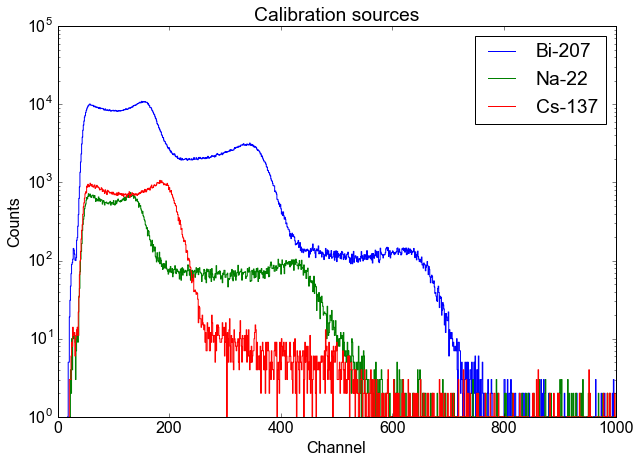

In [55]:
# Here we import the spectra one by one and plot them
my_colors = ['blue', 'green', 'red']
for filename, label, color in zip(cal_filenames_0, cal_labels_0, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    plt.plot(spec,linestyle='steps', label=label, color=color)
#     fwhm_pos = get_fwhm_pos(spec)
#     plt.axvline(get_fwhm_pos(spec), color=color)
plt.yscale('log')
plt.title("Calibration sources")
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.xlim(0,1000)
plt.legend()
plt.show()

In [56]:
# Now, determine the position of the Compton edges
# We make two lists: one storing the energy in keV and one the index of the half-max sample
energy_list   = []
fwhm_pos_list = []

for filename, label, color in zip(cal_filenames_0, cal_labels_0, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    if label == 'Bi-207':
        # Bi-207 has three gamma ray energies, so three Compton edges to find
        # https://ehs.ucsd.edu/rad/radionuclide/Bi-207.pdf
        energy_list.append(get_compton_energy(570.))
        fwhm_pos_list.append(get_fwhm_pos(spec))
        energy_list.append(get_compton_energy(1064.))
        fwhm_pos_list.append(get_fwhm_pos(spec[300:500]) + 300)
        energy_list.append(get_compton_energy(1770.))
        fwhm_pos_list.append(get_fwhm_pos(spec[500:800]) + 500)
    if label == 'Na-22':
        # From Na-22 we get 511 keV from positron allihilation and 1274 from gamma
        energy_list.append(get_compton_energy(511.))
        fwhm_pos_list.append(get_fwhm_pos(spec))
        energy_list.append(get_compton_energy(1274.))
        fwhm_pos_list.append(get_fwhm_pos(spec[300:600]) + 300)
    if label == 'Cs-137':
        # Only 662 keV
        energy_list.append(get_compton_energy(662.))
        fwhm_pos_list.append(get_fwhm_pos(spec))


Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


In [57]:
# Now perform the calibration based on linear fit
from scipy.optimize import curve_fit
p_scale, _ = curve_fit(poly_1, energy_list, fwhm_pos_list)
print("Offset: %.2f channels, slope: %.3f channels/keV" % (p_scale[0], p_scale[1]))

# Invert relation
p_scale_to_e = [- p_scale[0] / p_scale[1], 1 / p_scale[1]]
# e_scale is the important list: it contains the energy in keV
# This is basically the x axis for all our next plots!
e_scale = [poly_1(x, *p_scale_to_e) for x in range(4096)]


Offset: 12.60 channels, slope: 0.420 channels/keV


(0, 800)

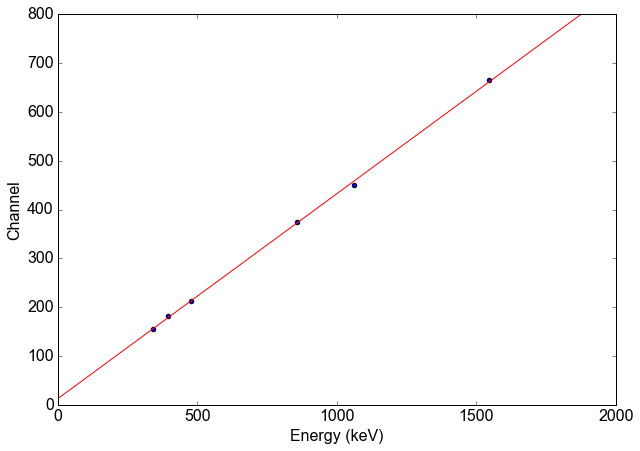

In [58]:
# Check out calibration
plt.scatter(energy_list, fwhm_pos_list)
plt.plot(range(2000), [poly_1(x, *p_scale) for x in range(2000)], color='red', label='Linear fit')
plt.xlabel('Energy (keV)')
plt.ylabel('Channel')
plt.xlim(0,2000)
plt.ylim(0,800)

In [59]:
energy_list

[393.57964869775896,
 857.9734748010609,
 1546.7292026660084,
 340.6666666666667,
 1061.1807780320366,
 477.650136239782]

Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


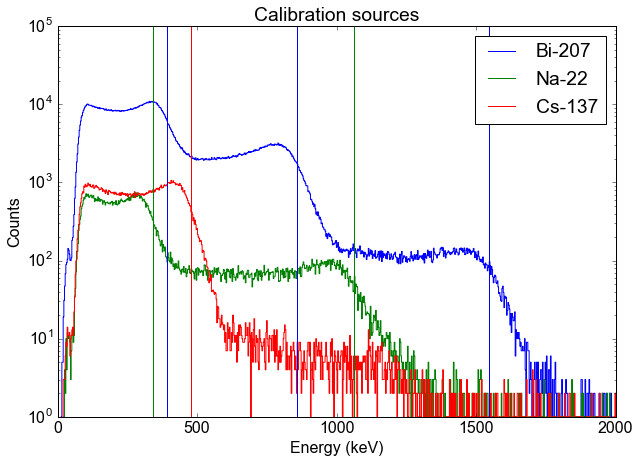

In [60]:
# Now plot the spectra again, but include with correct x scale and the Compton edge energy
my_colors = ['blue', 'green', 'red']
for filename, label, color in zip(cal_filenames_0, cal_labels_0, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    plt.plot(e_scale,spec,linestyle='steps', label=label, color=color)

for i, e in enumerate(np.sort(energy_list)):
    if i==0 or i==4:
        c = 'green'
    if i==1 or i==3 or i==5:
        c = 'blue'
    if i==2:
        c='red'
    plt.axvline(e, c=c)
plt.yscale('log')
plt.title("Calibration sources")
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.xlim(0,2000)
plt.legend()
plt.show()

### Load neutron and background data

In [61]:
# NG data
spec2d_list = []
for ng_filename in ng_filenames_0:
    line_n = find_line_start(ng_filename,'[CDAT2')
    spec2d_raw = get_spectrum(ng_filename, line_n)
    spec2d = np.reshape(spec2d_raw, (1024,4096))
    spec2d_list.append(spec2d)
#spec2d = sum(spec2d_list)

# NOTE THIS IS A NEW LINE... Only analize the first run, not all combined!
spec2d = spec2d_list[0]

Spectrum containing 4194304 samples read, total 976692 counts
Spectrum containing 4194304 samples read, total 1244420 counts
Spectrum containing 4194304 samples read, total 1867828 counts


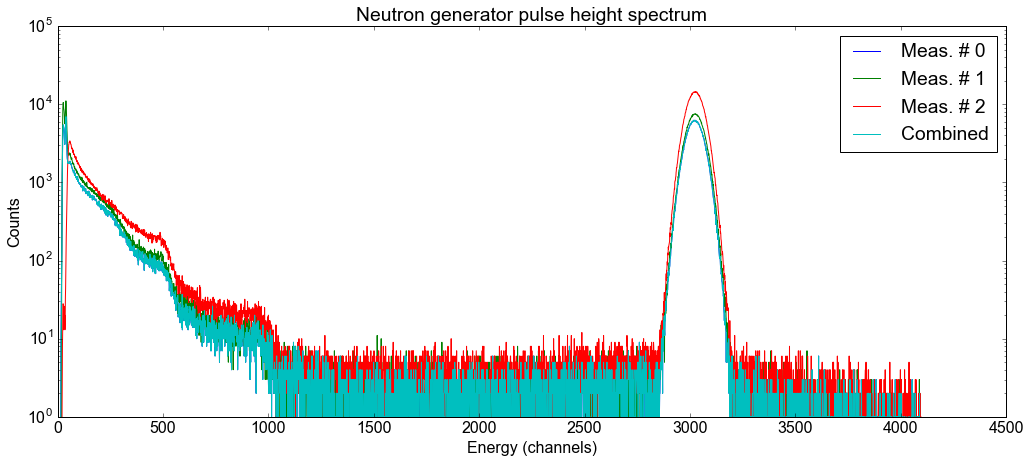

In [62]:
# Check that spectra coincide
scale_it = False # Toggle scaling by the total number of counts
plt.figure(figsize=(17,7))
for i, spec in enumerate(spec2d_list):
    if scale_it:
        norm_fac = 1./np.sum(spec)
    else:
        norm_fac = 1.
    plt.plot(norm_fac*np.sum(spec, axis=0), label='Meas. # %d' % i)
if scale_it:
    norm_fac = 1./np.sum(spec2d)
else:
    norm_fac = 1.
plt.plot(norm_fac*np.sum(spec2d, axis=0), label='Combined')
plt.yscale('log')
plt.legend()
plt.title('Neutron generator pulse height spectrum')
plt.xlabel('Energy (channels)')
if scale_it:
    plt.ylabel('Counts (normalized)')
else:
    plt.ylabel('Counts')
plt.show()

In [63]:
# BG data
spec2d_bg_list = []
for bg_filename in bg_filenames_0:
    line_n = find_line_start(bg_filename,'[CDAT2')
    spec2d_raw = get_spectrum(bg_filename, line_n)
    spec2d_bg = np.reshape(spec2d_raw, (1024,4096))
    spec2d_bg_list.append(spec2d_bg)
spec2d_bg = sum(spec2d_bg_list)

Spectrum containing 4194304 samples read, total 2968699 counts
Spectrum containing 4194304 samples read, total 3252444 counts


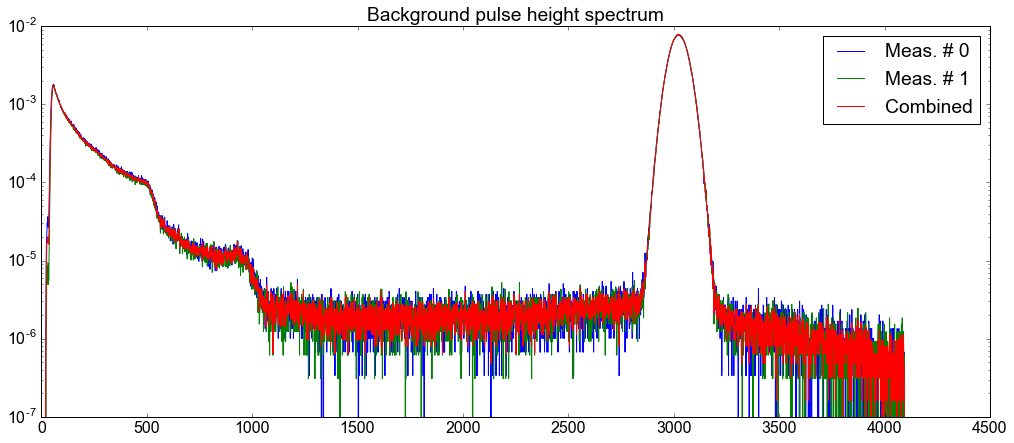

In [64]:
# Check that spectra coincide
scale_it = True # Toggle scaling by the total number of counts
plt.figure(figsize=(17,7))
for i, spec in enumerate(spec2d_bg_list):
    if scale_it:
        norm_fac = 1./np.sum(spec)
    else:
        norm_fac = 1.
    plt.plot(norm_fac*np.sum(spec, axis=0), label='Meas. # %d' % i)
if scale_it:
    norm_fac = 1./np.sum(spec2d_bg)
else:
    norm_fac = 1.
plt.plot(norm_fac*np.sum(spec2d_bg, axis=0), label='Combined')
plt.yscale('log')
plt.title('Background pulse height spectrum')
plt.legend()
plt.show()

### Cut background away

One thing we can do is cut the BG away based on the background discrimination parameter. For this, we have to calculate some cut parameter. I build a class to perform the cut based on a percentile of the BG distribution in y.

#### Cut class defintion

In [65]:
class Cut:
    '''
    Produce a cut function to cut on a percentile list.
    '''
    
    pct = 0.
    pct_list = [True for x in range(4096) ] 
    x_thr = 0.
    y_thr = 0.
    
    def get_percentile(self, spec2d, pct):
        self.pct_list = []
        self.pct = pct
        for x in range(len(spec2d[0])):
            self.pct_list.append(self.get_percentile_pos(spec2d[:,x],pct))
        
    def get_percentile_pos(self, dist, percent):
        tot = sum(dist)
        count = 0
        for i, x in enumerate(dist):
            if count >= tot*percent/100.:
                return i
            count += x
        # We should never arrive here
        print('WARNING! Error in get_percentile_pos')
        return -1
    
    def f_cut(self, x, y):
        '''
        FALSE = CUT
        TRUE = KEEP
        '''
        cut_y = self.pct_list[x-1]
        if y < cut_y:
            return False
        if x < self.x_thr:
            return False
        if y < self.y_thr:
            return False
        else:
            return True
        
    def plot_bounds(self, **kwargs):
        plt.plot(range(len(self.pct_list)), self.pct_list, **kwargs)
        plt.axvline(self.x_thr, **kwargs)
        plt.axhline(self.y_thr, **kwargs)
        
    def plot_percentile(self, **kwargs):
        plt.plot(range(len(self.pct_list)), self.pct_list, **kwargs)

#### Calculate cuts

In [66]:
cut_list = []
for percentile in [99.0, 99.5]:
    cut = Cut()
    cut.get_percentile(spec2d_bg, percentile)
    cut_list.append(cut)

#### Show cuts on background and foreground

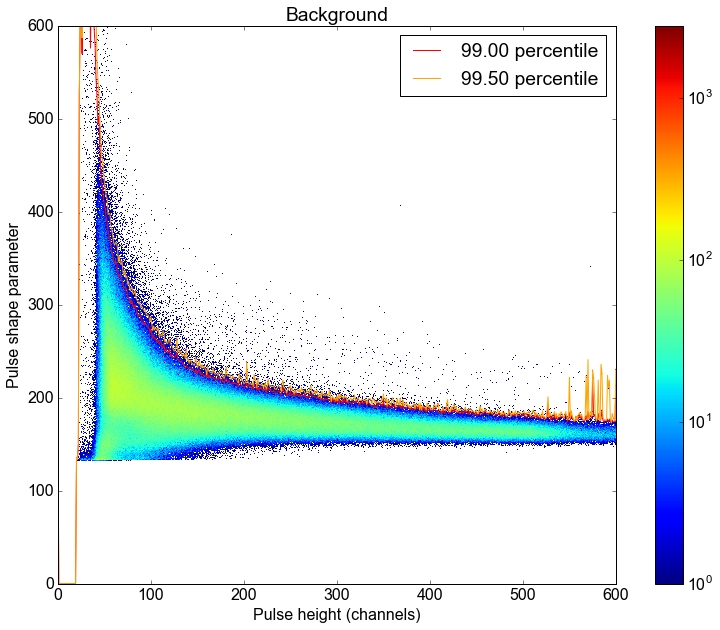

In [67]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d_bg, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
    cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('Background')
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

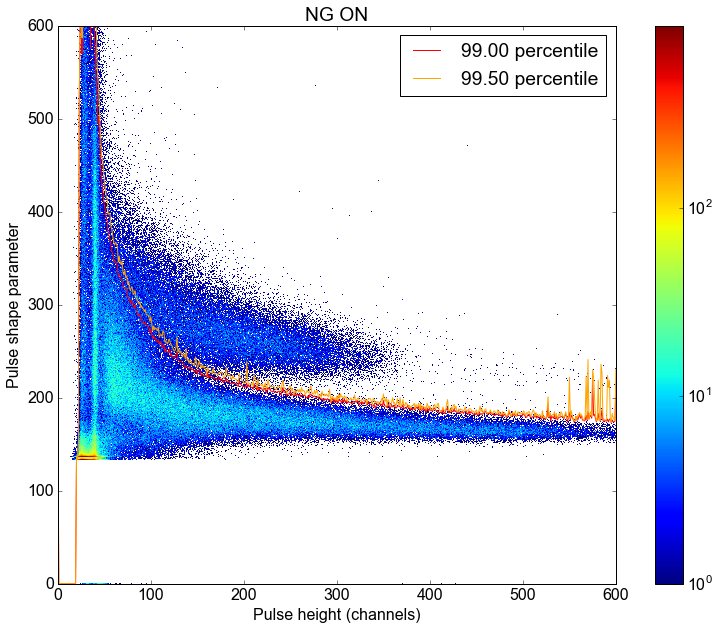

In [68]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
    cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('NG ON')
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

#### Apply cut

In [69]:
# cut_list[1] means we're taking the 99.5 % cut
cut = cut_list[1]
cut.x_thr = 60.
spec2d_cut = cut_hist2d(spec2d,cut.f_cut)
spec2d_bg_cut = cut_hist2d(spec2d_bg,cut.f_cut)

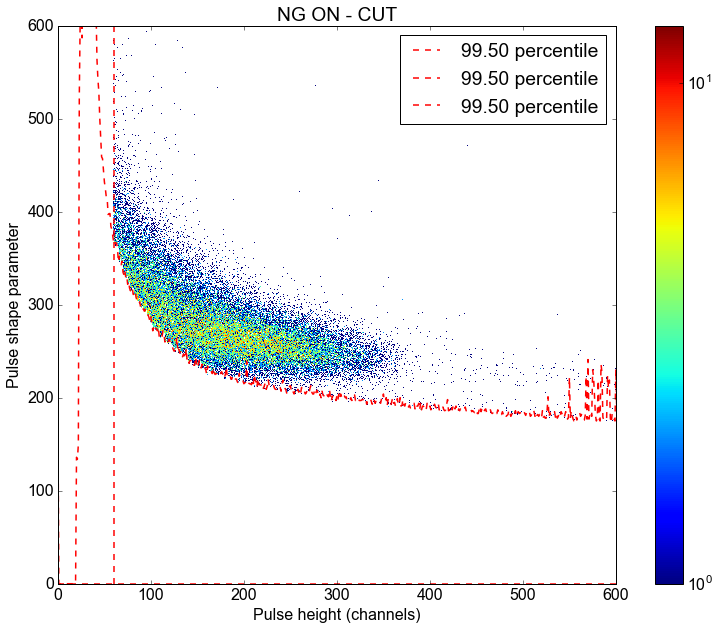

In [70]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d_cut, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('NG ON - CUT')
cut.plot_bounds(color='red', ls='--', lw=1.5, label='%.2f percentile' % cut.pct)
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

#### Show cut pulse height spectra

Here we show two things: the BG passing the cut (needs to be scaled by the livetime!) and the 

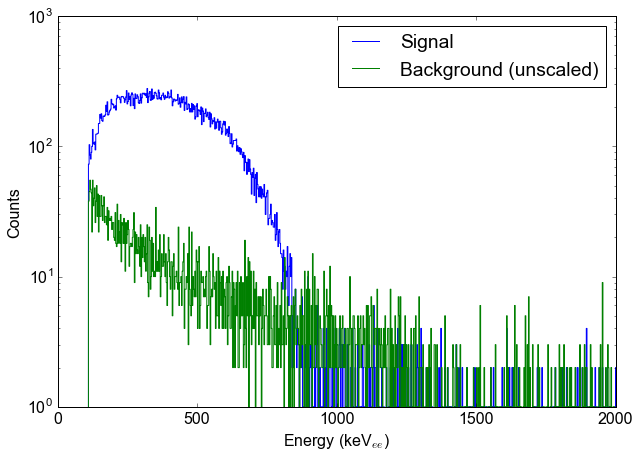

In [71]:
plt.plot(e_scale, np.sum(spec2d_cut, axis=0), linestyle = 'steps', label='Signal')
plt.plot(e_scale, np.sum(spec2d_bg_cut, axis=0), linestyle = 'steps', label='Background (unscaled)')
plt.xlim(0,2000)
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Counts')
plt.legend()
plt.show()


#### Rebinning

We rebin the x-scale to make the fit easier.
Maybe this is not necessary, though.

In [72]:
x1 = e_scale
f1 = np.sum(spec2d_cut, axis=0)
x2 = [e_scale[i] for i in np.arange(0, len(f1)-1, 2)]
f2 = [f1[i] + f1[i+1] for i in np.arange(0, len(f1)-1, 2)]
x3 = [e_scale[i] for i in np.arange(0, len(f1)-2, 3)]
f3 = [f1[i] + f1[i+1] + f1[i+2] for i in np.arange(0, len(f1)-2, 3)]
x4 = [e_scale[i] for i in np.arange(0, len(f1)-3, 4)]
f4 = [f1[i -1] + f1[i] + f1[i+1] + f1[i+2] for i in np.arange(1, len(f1)-2, 4)]

(0, 1000)

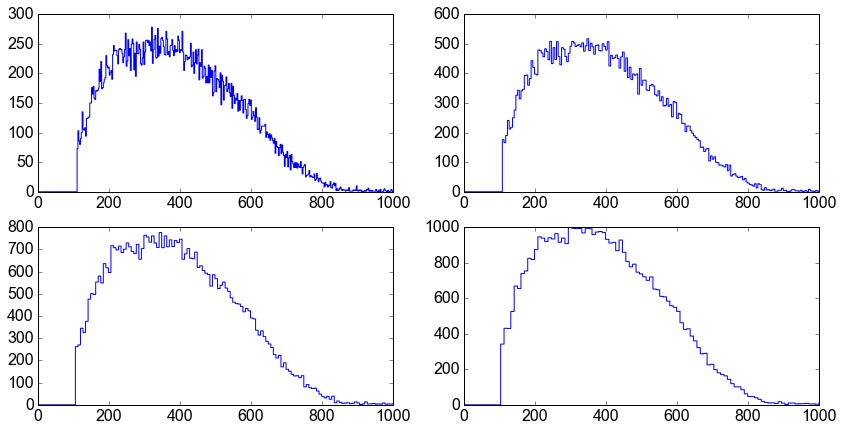

In [73]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(2,2,1)
plt.plot(x1, f1, linestyle='steps')
plt.xlim(0,1000)
fig.add_subplot(2,2,2)
plt.plot(x2, f2, linestyle='steps')
plt.xlim(0,1000)
fig.add_subplot(2,2,3)
plt.plot(x3, f3, linestyle='steps')
plt.xlim(0,1000)
fig.add_subplot(2,2,4)
plt.plot(x4, f4, linestyle='steps')
plt.xlim(0,1000)

In [74]:
x1 = np.array(x1)
x2 = np.array(x2)
x3 = np.array(x3)
x4 = np.array(x4)
f1 = np.array(f1)
f2 = np.array(f2)
f3 = np.array(f3)
f4 = np.array(f4)
f1_err = np.sqrt(np.array([f if f!=0 else 1 for f in f1]))
f2_err = np.sqrt(np.array([f if f!=0 else 1 for f in f2]))
f3_err = np.sqrt(np.array([f if f!=0 else 1 for f in f3]))
f4_err = np.sqrt(np.array([f if f!=0 else 1 for f in f4]))

### Try to subtract BG

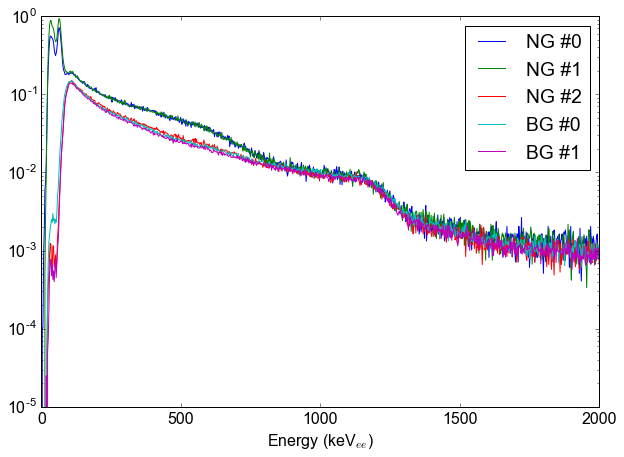

In [75]:
for i in range(len(spec2d_list)):
    plt.plot(e_scale, 1/ng_livetimes_0[i]*np.sum(spec2d_list[i],axis=0), label = 'NG #%d' % i)
for i in range(len(spec2d_bg_list)):
    plt.plot(e_scale, 1/bg_livetimes_0[i]*np.sum(spec2d_bg_list[i],axis=0), label = 'BG #%d' % i)

plt.xlabel('Energy (keV$_{ee}$)')
plt.legend()
plt.xlim(0,2000)
plt.yscale('log')

In [76]:
# Compute the livetime-corrected energy spectra
fg_0 = 1/ng_livetimes_0[0]*np.sum(spec2d_list[0],axis=0)
fg_1 = 1/ng_livetimes_0[1]*np.sum(spec2d_list[1],axis=0)
# Combine BG: take sum of counts and sum of livetimes
bg = (1/sum(bg_livetimes_0))*(np.sum(spec2d_bg_list[0],axis=0) + np.sum(spec2d_bg_list[1],axis=0))

# Compute the errors
fg_0_err = 1/ng_livetimes_0[0]*np.sqrt(np.sum(spec2d_list[0],axis=0))
fg_1_err = 1/ng_livetimes_0[1]*np.sqrt(np.sum(spec2d_list[1],axis=0))
bg_err = (1/sum(bg_livetimes_0))*np.sqrt(
    (np.sum(spec2d_bg_list[0],axis=0) + np.sum(spec2d_bg_list[1],axis=0)))

# Subtract BG
fg_0_sub = fg_0 - bg
fg_1_sub = fg_1 - bg

# Compute errors for subtracted BG plot
fg_0_sub_err = np.sqrt(fg_0_err**2 + bg_err**2)
fg_1_sub_err = np.sqrt(fg_1_err**2 + bg_err**2)


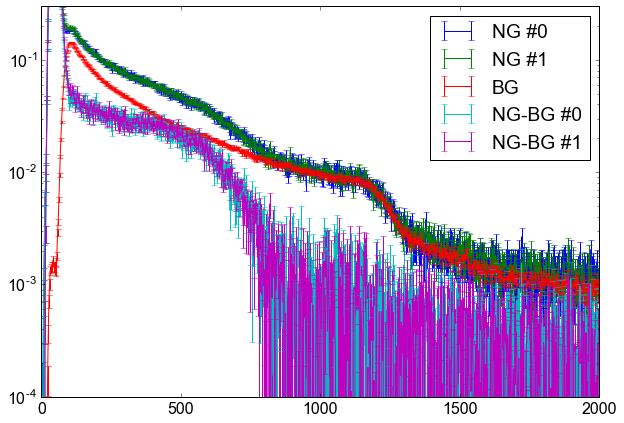

In [77]:
plt.errorbar(e_scale, fg_0, yerr=fg_0_err, label='NG #0')
plt.errorbar(e_scale, fg_1, yerr=fg_1_err, label='NG #1')
plt.errorbar(e_scale, bg, yerr=bg_err, label='BG')
plt.errorbar(e_scale, fg_0_sub, yerr=fg_0_sub_err, label='NG-BG #0')
plt.errorbar(e_scale, fg_1_sub, yerr=fg_1_sub_err, label='NG-BG #1')

plt.yscale('log')
plt.ylim(10**-4, 0.3)
plt.xlim(0,2000)
plt.legend()
plt.show()

### Investigate high energy population

We've seen in the data that there seems to be a high-energy population of nuclear recoils, probably due to D-T fusion. At these high energies, it might make sense to take a slightly different aapproach. Thi is because:
  * The statistics are very low, in signal as well as background, and the binning is terribly fine.
  * The discrimination gets pretty good and easy at high energy: the gamma and neutron bands get well-separated and 

In [78]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

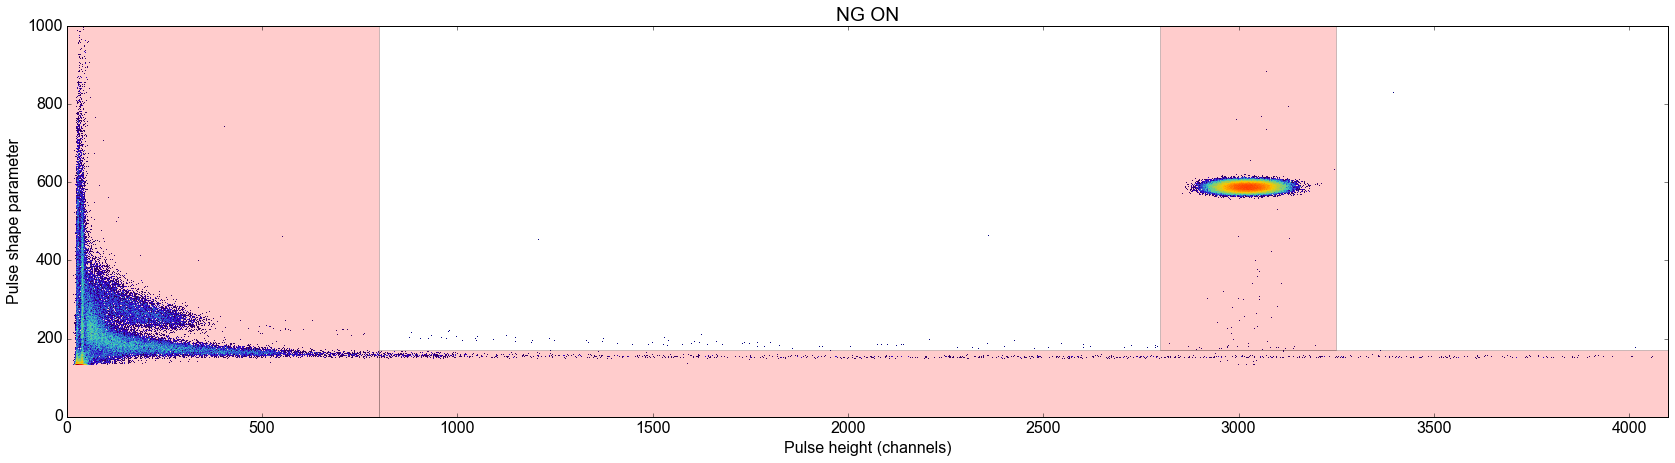

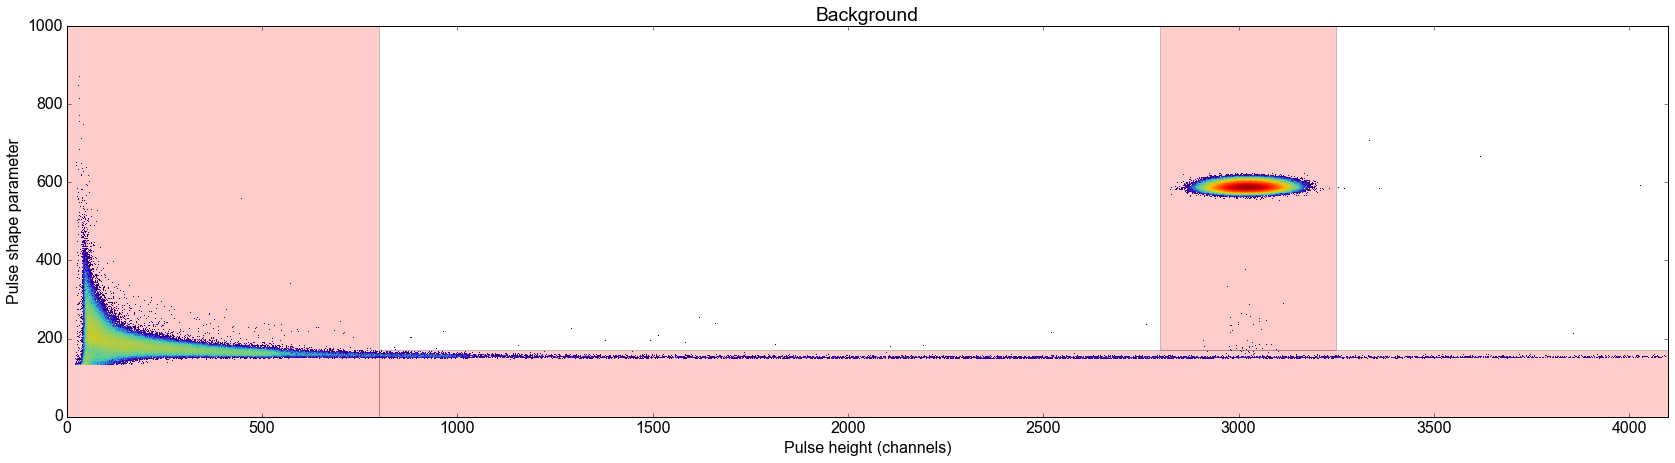

In [132]:
plt.figure(figsize=(30,7))
im = plt.imshow(spec2d_list[0], origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
plt.xlim(0,4100)
plt.ylim(0,1000)
plt.title('NG ON')
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
draw_box((0,800),(0,1024),facecolor='red', alpha=0.2, ls=None)
draw_box((800,4100),(0,170),facecolor='red', alpha=0.2, ls=None)
draw_box((2800,3250),(170,1000),facecolor='red', alpha=0.2, ls=None)
plt.show()

plt.figure(figsize=(30,7))
im = plt.imshow(spec2d_bg, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
plt.xlim(0,4100)
plt.ylim(0,1000)
plt.title('Background')
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
draw_box((0,800),(0,1024),facecolor='red', alpha=0.2, ls=None)
draw_box((800,4100),(0,170),facecolor='red', alpha=0.2, ls=None)
draw_box((2800,3250),(170,1000),facecolor='red', alpha=0.2, ls=None)
plt.show()



In [103]:
spec_high = spec2d_list[0].copy()
entries_high = []

for i in range(len(spec_high)):
    # i loops over discimination paramter
    for j in range(len(spec_high[0])):
        if j < 800:
            spec_high[i,j] = 0 
        elif j < 3250 and j > 2800:
            spec_high[i,j] = 0
        elif i< 170:
            spec_high[i,j] = 0
        else:
            for k in range(spec_high[i,j]):
                entries_high.append(j)
                
spec_high_bg = spec2d_bg.copy()
entries_high_bg = []

for i in range(len(spec_high_bg)):
    # i loops over discimination paramter
    for j in range(len(spec_high_bg[0])):
        if j < 800:
            spec_high_bg[i,j] = 0 
        elif j < 3250 and j > 2800:
            spec_high_bg[i,j] = 0
        elif i< 170:
            spec_high_bg[i,j] = 0
        else:
            for k in range(spec_high_bg[i,j]):
                entries_high_bg.append(j)

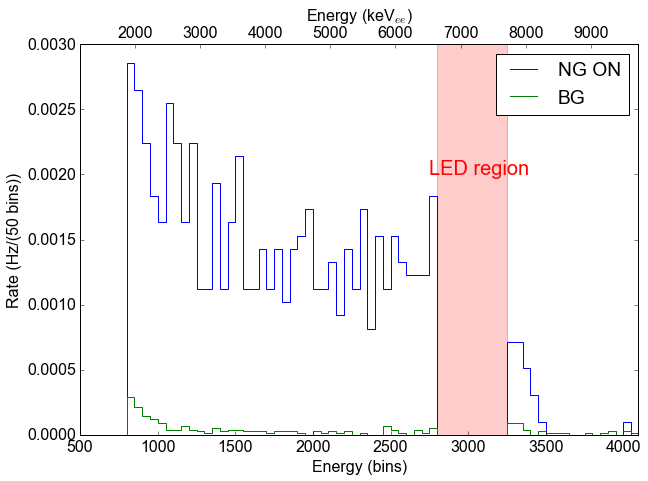

In [183]:
entries_ng, bins_e  = np.histogram(entries_high,bins=80, range=(500,4500))
entries_bg, bins_e  = np.histogram(entries_high_bg,bins=80, range=(500,4500))

bins_e_centers = 0.5*(bins_e[:-1] + bins_e[1:])

plt.plot(bins_e[1:],1/ng_livetimes_0[0]*entries_ng,linestyle='steps',label='NG ON')
plt.plot(bins_e[1:],1/sum(bg_livetimes_0)*entries_bg,linestyle='steps',label='BG')

draw_box((2800,3250),(0,0.0030), facecolor='red', alpha=0.2)
plt.ylim(0,0.0030)
plt.xlim(500,4095)
plt.xlabel('Energy (bins)')
plt.ylabel('Rate (Hz/(50 bins))')
plt.legend()
plt.text(2750,0.002, 'LED region', color='red', fontsize=20)

# Make a second x axis that shows the actual energy in keVee
plt.twiny()
plt.xlim(e_scale[500], e_scale[4095])
plt.xlabel('Energy (keV$_{ee}$)')
plt.show()


In [178]:
plt.text?
